In [8]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

import pysindy as ps

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from toolbox.auxiliary_functions import set_param_freq

# Seed:
np.random.seed(999)

### Case $\rho$ varying
Consider the following fractional system of ODEs: 
$$
\begin{cases}
\dot{x}_0 = \dfrac{x_0^2}{x_1 + \rho} \\[10pt]
\dot{x}_1 = 1
\end{cases}
$$

With $\rho\in[1,2]$ varying.

In [9]:
# Select ODE & settings:
ode_name = 'FracODE_par_rho' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [5]:
# # Generate data:
# X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
# print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
# print(feature_names)

# # Save data:
# file_path = 'saved/data/fracODE_par_rho_data.pkl'
# os.makedirs(os.path.dirname(file_path), exist_ok=True)
# with open(file_path, 'wb') as f:
#     dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 30, 2) (50, 30, 2) (50, 30)
['X0', 'X1', 'X2']


In [10]:
# Uploda data:
file_path = 'saved/data/fracODE_par_rho_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(50, 30, 2) (50, 30, 2) (50, 30)
['X0', 'X1', 'X2']


Threshold:  0.01 , RMSE:  0.04915985310740944
Threshold:  0.05 , RMSE:  0.05505199039979086
Threshold:  0.1 , RMSE:  0.053500673436612314
Threshold:  0.2 , RMSE:  0.12459116381403364
Threshold:  0.4 , RMSE:  0.4623196907095647
Threshold:  0.6 , RMSE:  0.4623196907095647


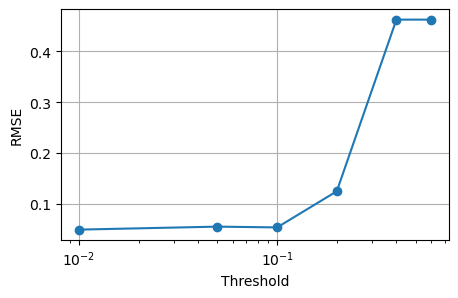

In [12]:
# Model selection:
thresholds = np.array([0.01, 0.05, 0.1, 0.2, 0.4, 0.6])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list, u=param_list)
    rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, [1., 1., 2.], [0.8, 0.8, 1.], dim_k)
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)  

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

In [13]:
# Best model fit
model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list, u=param_list)
print("Estimated SINDy model: ")
model.print()

Estimated SINDy model: 
(X0)' = 0.589 1 + -1.762 X0 + 0.824 X1 + 1.657 X0^2 + -0.355 X0 X1 + -0.116 X0 X2 + -0.239 X1^2 + -0.391 X0^2 X1 + 0.224 X0 X1^2
(X1)' = 1.003 1


##### Plot for report

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_traj(model, ode, freq, n_sample, init_high, init_low, dim_x=1, dim_k=1, title=None, T_aux=100):

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux + dt, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # true trajectories:
    # Assumiamo che 'data' sia disponibile nell'ambiente
    dg_true = data.DataGenerator(ode, T_aux, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        t = np.arange(0, T_aux, dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot, 1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t=t[:T_plot], u=test_params)
        else:
            pred_0 = model.simulate(xt_true[0, i, :], t=t[:T_plot])
        pred_0_list.append(pred_0)

    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()

    if n_sample == 1:
        if dim_x == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(time_vector, pred_0_list, color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(time_vector, xt_true, color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(time_vector[0], xt_true[0], color='green', label=r'Start')
            ax.scatter(time_vector[-1], xt_true[-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')
            ax.set_ylabel(r'$x$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='upper left')
            ax.grid(True)

        elif dim_x == 2:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            # INVERTIAMO x1 e x2 nei dati
            ax.plot(pred_0_list[:, 1], pred_0_list[:, 0],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 1], xt_true[:, 0],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 1][0], xt_true[:, 0][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 1][-1], xt_true[:, 0][-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')  # ORIZZONTALE → t
            ax.set_ylabel(r'$x$')  # VERTICALE → x
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='upper left')
            ax.grid(True)


        else:  # dim_x == 3
            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1], pred_0_list[:, 2],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 0], xt_true[:, 1], xt_true[:, 2],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], xt_true[:, 2][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], xt_true[:, 2][-1], color='red', label=r'End')
            ax.set_xlabel(r'$x$')
            ax.set_ylabel(r'$y$')
            ax.set_zlabel(r'$z$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='upper left')
            ax.grid(True)


Best Model RMSE:  0.06771399179030059


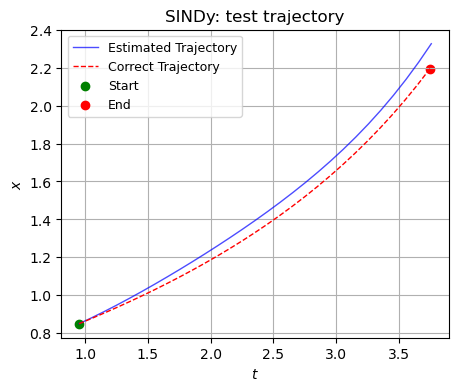

In [18]:
# Evaluation: within the training -> RMSE and reconstruction
n_test = 10
rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_test, [1., 1., 2], [0.8, 0.8, 1], dim_k)
print('Best Model RMSE: ', rmse)

evaluate_sample = 1
ics = [0.85, 0.95, 1.7]
title = 'SINDy: test trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux = 3)

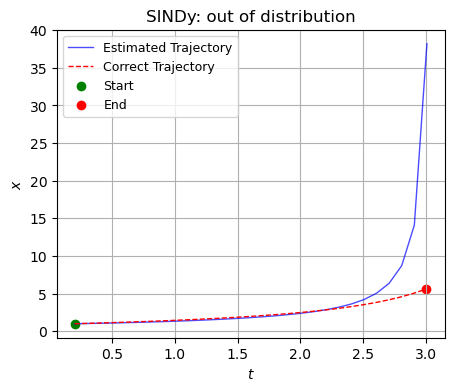

In [49]:
# Evaluation: within the training -> RMSE and reconstruction
evaluate_sample = 1
ics = [1, 0.2, 2]
title = 'SINDy: out of distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux = 3)

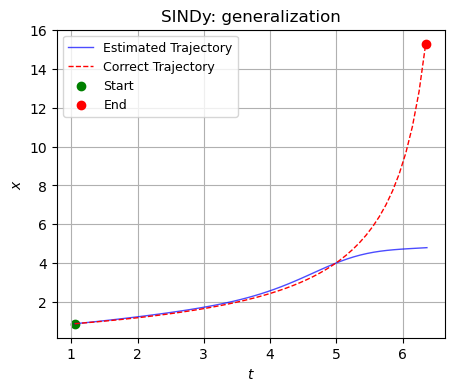

In [28]:
evaluate_sample = 1
ics = [0.85, 0.95, 1.7]
title = 'SINDy: generalization'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux = 5.5)